In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
from datetime import datetime
import os
import time
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
main_url="https://townhall.virginia.gov/L/Comments.cfm?GdocForumID=1953"

orig_url="https://townhall.virginia.gov/L/GDocForum.cfm?GDocForumID=452"

## Alt method - full comments page, paginated

In [2]:
base_url = "https://townhall.virginia.gov/L/ViewComments.cfm?GdocForumID=1953"
params = {"vPage": 1,
  "vPerPage": 999,
  "sub1": "go"}

In [3]:
pagecount = 99
params['vPage'] = 1

dfc = pd.DataFrame()

while params['vPage'] <= pagecount:
    r = requests.post(base_url, data=params)
    soup = BeautifulSoup(r.text, "lxml")
    try:
        pagecount = int(soup.find(id="page").div.a.text)
    except:
        pagecount = 0
    print(f"page {params['vPage']}/{pagecount}")
    params['vPage'] += 1
    boxes = soup.find_all(attrs={"class": "Cbox"})
    for box in boxes:
        comment = {"Date": unicodedata.normalize("NFKD", box.contents[1].div.get_text(strip=True)),
           "Commenter": box.contents[3].contents[2].strip(),
           "Comment Title": box.contents[3].find_all('strong')[1].get_text(strip=True),
           "Comment": box.find(attrs={"class":"divComment"}).get_text(strip=True),
           "CommentID": int(box.find(attrs={"class":"linklight"}).get_text(strip=True))}
        dfc = dfc.append(comment, ignore_index=True)


page 1/53
page 2/53
page 3/53
page 4/53
page 5/53
page 6/53
page 7/53
page 8/53
page 9/53
page 10/53
page 11/53
page 12/53
page 13/53
page 14/53
page 15/53
page 16/53
page 17/53
page 18/53
page 19/53
page 20/53
page 21/53
page 22/53
page 23/53
page 24/53
page 25/53
page 26/53
page 27/53
page 28/53
page 29/53
page 30/53
page 31/53
page 32/53
page 33/53
page 34/53
page 35/53
page 36/53
page 37/53
page 38/53
page 39/53
page 40/53
page 41/53
page 42/53
page 43/53
page 44/53
page 45/53
page 46/53
page 47/53
page 48/53
page 49/53
page 50/53
page 51/53
page 52/53
page 53/53


In [4]:
print(dfc.shape)
print(len(dfc['CommentID'].unique()))

(52229, 5)
52201


In [5]:
dfc.to_csv('all_comments.csv')

In [6]:
# read back from csv

In [7]:
# feature eng

In [8]:
dfc['Date'] = pd.to_datetime(dfc['Date'], errors='coerce') 

In [9]:
dfc['alltext'] = (dfc['Comment Title'] + ' ' + dfc['Comment']).str.lower()

In [10]:
dfc['support'] = dfc['Comment Title'].str.lower().str.contains('support')
dfc['oppose'] = dfc['Comment Title'].str.lower().str.contains('oppose')

In [11]:

print(f"Total: {dfc.shape[0]} comments")
print("Using title alone...")
print(f"Support policy: {dfc['support'].sum()} comments, avg length {dfc.loc[dfc['support']]['Comment'].str.len().mean():.0f}")
print(f"Oppose policy: {dfc['oppose'].sum()} comments, avg length {dfc.loc[dfc['oppose']]['Comment'].str.len().mean():.0f}")
print(f"Unclear: {(~dfc['support'] & ~dfc['oppose']).sum()} comments, avg length {dfc.loc[(~dfc['support'] & ~dfc['oppose'])]['Comment'].str.len().mean():.0f}")
print(f"Intersect: {(dfc['support'] & dfc['oppose']).sum()}")

Total: 52229 comments
Using title alone...
Support policy: 10359 comments, avg length 195
Oppose policy: 17160 comments, avg length 217
Unclear: 24912 comments, avg length 168
Intersect: 202


In [12]:
# process text field
cleantext = []

for sentence in dfc['alltext']:
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(sentence))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    cleantext.append(processed_feature)
    
dfc['cleantext'] = cleantext

In [13]:
# segment training data from unknown data

dfc['label'] = 'Unknown'
dfc.loc[dfc['support'],'label'] = 'Support'
dfc.loc[dfc['oppose'],'label'] = 'Oppose'
dfc.loc[(dfc['support'] & dfc['oppose']), 'label'] = 'Unknown'

train = dfc.loc[dfc['label'] != 'Unknown',:]
unk = dfc.loc[dfc['label'] == 'Unknown']

In [14]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(train['cleantext']).toarray()


In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(processed_features, train['label'], test_size=0.2, random_state=0)

In [16]:
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [17]:
predictions = text_classifier.predict(X_test)

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[3367    3]
 [  44 2009]]
              precision    recall  f1-score   support

      Oppose       0.99      1.00      0.99      3370
     Support       1.00      0.98      0.99      2053

    accuracy                           0.99      5423
   macro avg       0.99      0.99      0.99      5423
weighted avg       0.99      0.99      0.99      5423

0.9913332104001475


In [19]:
unk_input = vectorizer.transform(unk['cleantext']).toarray() # don't re-fit the vectorizer!
real_preds = text_classifier.predict(unk_input)
unk['pred'] = real_preds

/home/kfinity/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
unk.groupby(['pred']).count()

,Comment,Comment Title,CommentID,Commenter,Date,alltext,support,oppose,cleantext,label
pred,,,,,,,,,,
Oppose,22379,22379,22379,22379,22379,22379,22379,22379,22379,22379
Support,2735,2735,2735,2735,2735,2735,2735,2735,2735,2735


In [21]:
train.groupby(['label']).count()

,Comment,Comment Title,CommentID,Commenter,Date,alltext,support,oppose,cleantext
label,,,,,,,,,
Oppose,16958,16958,16958,16958,16958,16958,16958,16958,16958
Support,10157,10157,10157,10157,10157,10157,10157,10157,10157


In [22]:
train['pred'] = ''
output_df = train.loc[:,['CommentID','Commenter','Comment Title','Comment','Date','label','pred']]
output_df = output_df.append(unk.loc[:,['CommentID','Commenter','Comment Title','Comment','Date','label','pred']])

/home/kfinity/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
output_df.to_csv('output.csv',index=False)

In [24]:
anon = output_df.loc[output_df['Commenter'].str.lower().str.strip() == 'anonymous']
anon['merged'] = anon['pred'].replace('',np.NaN).fillna(anon['label'])
anon.groupby('merged')['CommentID'].count()

/home/kfinity/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


merged
Oppose     22883
Support     9147
Name: CommentID, dtype: int64

In [25]:
anon.shape

(32030, 8)

## Timeseries

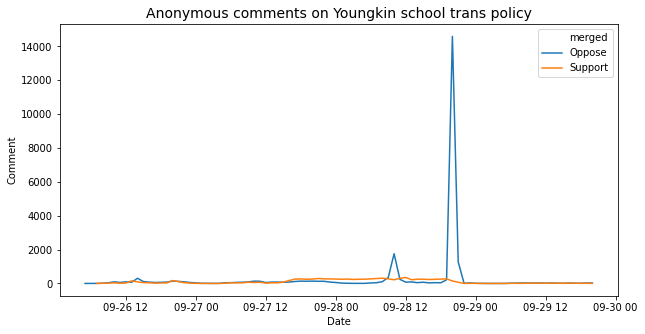

In [26]:
anon_ts = anon.set_index('Date').groupby([pd.Grouper(freq='1h'), 'merged']).count().loc[:,['Comment']].reset_index()

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x = 'Date', y = 'Comment', data = anon_ts, hue = 'merged', ax=ax)
ax.set_title('Anonymous comments on Youngkin school trans policy', fontsize=14)
plt.savefig("images/anon_ts.png", facecolor='white')
plt.show()

In [61]:
anon_dups = anon.groupby(['Comment Title','Comment']).agg({"CommentID":'count','Date':['min','max']})
anon_dups.columns = ['count','min_date','max_date']
anon_dups['range'] = (anon_dups['max_date'] - anon_dups['min_date'])
anon_dups.sort_values('count', ascending=False).head(10)

,,count,min_date,max_date,range
Comment Title,Comment,,,,
SUPPORT,SUPPORT,42,2022-09-27 09:52:00,2022-09-27 09:58:00,0 days 00:06:00
Oppose,Oppose,37,2022-09-26 20:21:00,2022-09-29 20:09:00,2 days 23:48:00
FULLY SUPPORT!!!,FULLY SUPPORT!!!,32,2022-09-26 20:51:00,2022-09-28 18:19:00,1 days 21:28:00
Strongly support Youngkin,Thank you,32,2022-09-26 21:03:00,2022-09-28 17:59:00,1 days 20:56:00
Fully support!!!,Our family fully supports this! Thank you Youngkin!,31,2022-09-26 21:31:00,2022-09-28 21:20:00,1 days 23:49:00
Strongly support a parents right to raise their child.,School systems are not medical professionals that are in the profession of diagnosing gender dysphoria in children. School systems do not pay the medical bills of these children.,31,2022-09-26 20:11:00,2022-09-28 17:15:00,1 days 21:04:00
I strongly support this. As a young woman,I want to feel safe in my sport and bathrooms.,31,2022-09-27 17:47:00,2022-09-28 19:11:00,1 days 01:24:00
I support,This is not something that should be pushed in schools. No little girl should have to feel uncomfortable because men can go into same restrooms as them. If we allow this than in the future pedophiles will be able to demand same rights and that is unacceptable!,30,2022-09-27 16:19:00,2022-09-28 21:12:00,1 days 04:53:00
Strongly support,Please help all children be safe. Transgender students in restrooms has resulted in assaults. Assigned restrooms for those with special needs should be available. At the high school where I taught,30,2022-09-27 17:27:00,2022-09-28 19:49:00,1 days 02:22:00


<AxesSubplot:>

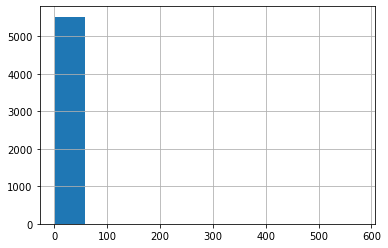

In [275]:
anon_dups['count'].hist()

In [62]:
# drop dups with <5
anon_dups.reset_index(inplace=True)
anon_dups = anon_dups.loc[(anon_dups['count']>5)]
anon_dups.set_index(['Comment Title','Comment'], inplace=True)

In [63]:
anon_dups.sort_values('count', ascending=False).head(5)


,,count,min_date,max_date,range
Comment Title,Comment,,,,
SUPPORT,SUPPORT,42,2022-09-27 09:52:00,2022-09-27 09:58:00,0 days 00:06:00
Oppose,Oppose,37,2022-09-26 20:21:00,2022-09-29 20:09:00,2 days 23:48:00
FULLY SUPPORT!!!,FULLY SUPPORT!!!,32,2022-09-26 20:51:00,2022-09-28 18:19:00,1 days 21:28:00
Strongly support Youngkin,Thank you,32,2022-09-26 21:03:00,2022-09-28 17:59:00,1 days 20:56:00
Strongly support a parents right to raise their child.,School systems are not medical professionals that are in the profession of diagnosing gender dysphoria in children. School systems do not pay the medical bills of these children.,31,2022-09-26 20:11:00,2022-09-28 17:15:00,1 days 21:04:00


In [64]:
# drop duplicates from Anon set
anon.set_index(['Comment Title','Comment'], inplace=True)
print(anon.loc[anon.index.isin(anon_dups.index)].shape[0]) # number of duplicates entered by bots ~18000
anon = anon.loc[~anon.index.isin(anon_dups.index)]
anon.reset_index(inplace=True)

6563


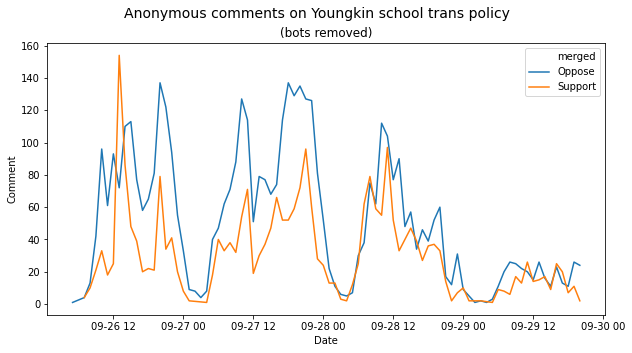

In [68]:
anon_ts = anon.set_index('Date').groupby([pd.Grouper(freq='1h'), 'merged']).count().loc[:,['Comment']].reset_index()

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x = 'Date', y = 'Comment', data = anon_ts, hue = 'merged', ax=ax)
fig.suptitle('Anonymous comments on Youngkin school trans policy', fontsize=14)
ax.set_title('(bots removed)')
plt.savefig("images/anon_ts_nobots.png", facecolor='white')
plt.show()

In [69]:
anon.loc[(anon['merged']=='Support') & (anon['Date'] > datetime(2022, 9, 28, 2, 0)) ].head(20)

,Comment Title,Comment,CommentID,Commenter,Date,label,pred,merged
2753,"As a Christian who loves all people, I cannot ...",Bad law.,153596.0,Anonymous,2022-09-28 02:01:00,Support,,Support
2754,Fully support this.,Support!,153599.0,Anonymous,2022-09-28 02:01:00,Support,,Support
2758,I support parents rights.,It's completely ridiculous that anyone is oppo...,153625.0,Anonymous,2022-09-28 02:06:00,Support,,Support
2759,what a horribly hateful law. I do NOT support,bad law.,153627.0,Anonymous,2022-09-28 02:06:00,Support,,Support
2760,you cannot be Christain and support this!,don't pass.,153636.0,Anonymous,2022-09-28 02:08:00,Support,,Support
2761,I am a teacher and I do NOT support this. I wi...,NO!,153648.0,Anonymous,2022-09-28 02:10:00,Support,,Support
2763,Strongly support,Strongly support. Parents don't hand over pare...,153669.0,Anonymous,2022-09-28 02:15:00,Support,,Support
2764,100% Support Parents Rights,They can change their name “ pronouns “ every...,153698.0,Anonymous,2022-09-28 02:20:00,Support,,Support
2765,100% support Governor Youngkin's Model Policies,I'm am so glad to see some common sense in Ric...,153711.0,Anonymous,2022-09-28 02:23:00,Support,,Support
2767,100% Support for Gov Youngkin’s Commonsense P...,Governor Youngkin’s policy is reasonable and p...,153808.0,Anonymous,2022-09-28 02:46:00,Support,,Support


In [74]:
anon

,Comment Title,Comment,CommentID,Commenter,Date,label,pred,merged
0,Support!,"As a public school teacher, THANK YOU! I don't...",128971.0,Anonymous,2022-09-26 07:31:00,Support,,Support
1,Strongly support all people being who they are,Everyone is different. Everyone deserves to be...,128976.0,Anonymous,2022-09-26 07:38:00,Support,,Support
2,This is about saving student lives - oppose th...,I strongly oppose these changes. Having worked...,128984.0,Anonymous,2022-09-26 07:54:00,Oppose,,Oppose
3,Strongly Oppose The Changes,Correct pronoun and name use is incredibly cri...,128992.0,Anonymous,2022-09-26 08:12:00,Oppose,,Oppose
4,Strongly Oppose,Leave the evangelists to do their Work outside...,128998.0,Anonymous,2022-09-26 08:18:00,Oppose,,Oppose
...,...,...,...,...,...,...,...,...
7112,Trans people,I feel that trans people should be able to dec...,181340.0,Anonymous,2022-09-29 19:49:00,Unknown,Oppose,Oppose
7113,Best practice,"As a professional educator, this is a very sim...",181348.0,Anonymous,2022-09-29 19:52:00,Unknown,Support,Support
7114,100% agree with Governor Youngkin‘s policies o...,Honest doctors know that gender dysphoria is s...,181382.0,Anonymous,2022-09-29 20:13:00,Unknown,Support,Support
7115,"Duh, repeat post much?",Free for all,181396.0,Anonymous,2022-09-29 20:20:00,Unknown,Oppose,Oppose


In [84]:
# drop duplicates from Output set
dups = output_df.groupby(['Comment Title','Comment']).count().loc[:,['CommentID']]
dups = dups.loc[dups['CommentID']>5] # 396 comments
output_df.set_index(['Comment Title','Comment'], inplace=True)
print(f"Duplicates removed: {output_df.loc[output_df.index.isin(dups.index)].shape[0]}") 
output_df = output_df.loc[~output_df.index.isin(dups.index)]
output_df.reset_index(inplace=True)
print(f"Remaining records: {output_df.shape[0]}")

Duplicates removed: 32629
Remaining records: 19600


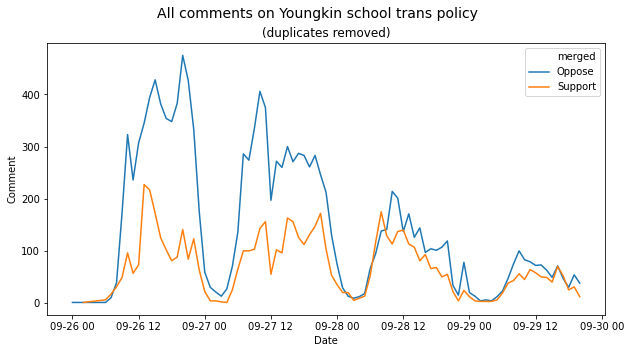

In [86]:
output_df['merged'] = output_df['pred'].replace('',np.NaN).fillna(output_df['label'])
out_ts = output_df.set_index('Date').groupby([pd.Grouper(freq='1h'), 'merged']).count().loc[:,['Comment']].reset_index()

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x = 'Date', y = 'Comment', data = out_ts, hue = 'merged', ax=ax)
fig.suptitle('All comments on Youngkin school trans policy', fontsize=14)
ax.set_title('(duplicates removed)')
plt.savefig("images/all_ts.png", facecolor='white')
plt.show()

In [92]:
counts = output_df.groupby('merged')['CommentID'].count()
data = counts.values
labels = list(counts.index)


output_orig = train.loc[:,['CommentID','Commenter','Comment Title','Comment','Date','label','pred']]
output_orig = output_orig.append(unk.loc[:,['CommentID','Commenter','Comment Title','Comment','Date','label','pred']])
output_orig['merged'] = output_orig['pred'].replace('',np.NaN).fillna(output_orig['label'])
counts2 = output_orig.groupby('merged')['CommentID'].count()
data2 = counts2.values
labels2 = list(counts2.index)

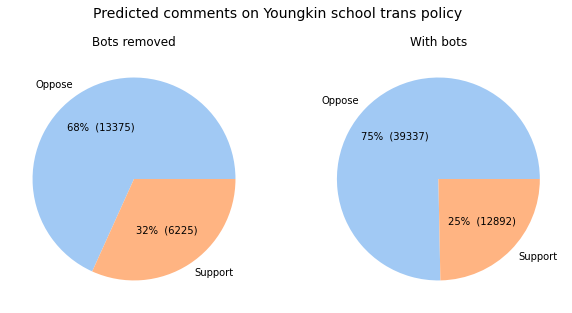

In [100]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.0f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct


#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Predicted comments on Youngkin school trans policy', fontsize=14)

ax1.pie(data, labels = labels, colors = colors, autopct=make_autopct(data))
ax1.set_title('Bots removed')

ax2.pie(data2, labels = labels2, colors = colors, autopct=make_autopct(data2))
ax2.set_title('With bots')

plt.savefig("images/outcome_pie.png", facecolor='white')
plt.show()

In [98]:
output_orig.shape

(52229, 8)